In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge, Input

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## prepare data

In [2]:
def double_integrate(df, col):
    df.sort_values(by='t', inplace=True)
    velocities = df[col].cumsum()
    positions = velocities.cumsum()
    return positions
# load data
def load_data_time(directory = 'data/group3/config_1', all_data=[], labels=[]):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        data = pd.read_csv(f)
        data['pos_x'] = double_integrate(data,'raw_acceleration_x')
        data['pos_y'] = double_integrate(data,'raw_acceleration_y')
        data['pos_z'] = double_integrate(data,'raw_acceleration_z')
        all_data.append(np.array(data))
        # formatage des labels pour chaque pas de temps
        if directory == 'data/h_config1-lcb':
            _label = int(filename[2])
        elif directory == 'data/v_config1-lcb':
            _label = int(filename[10])
        elif directory == 'data/groupe1_groupe2':
            _label = int(filename.split('_')[1])
        else :
            _label = int(filename[0])
        labels.append(np.array([_label]*len(data)).reshape(-1,1))
    columns_name = pd.read_csv(os.path.join(directory, os.listdir(directory)[1])).columns.tolist()
    return all_data, labels, columns_name

# load horizontal
all_data, labels, _ = load_data_time()
# # print(len(all_data))
# all_data, labels, _ = load_data_time('data/h_config1-lcb',all_data,labels)
# print(len(all_data))
# # load vertical
# all_data, labels, _ = load_data_time('data/v_config1-lcb',all_data,labels)
# print(len(all_data))
# # load 3D
# all_data, labels, _ = load_data_time('data/groupe1_groupe2',all_data,labels)
# print(len(all_data))

#### process label 
* we need one hot encoded matrice for classification with reservoirpy
* we need a class for each time_step
* we process before the train_test_split for convenience

In [3]:
enc = OneHotEncoder()
enc.fit_transform(np.array(np.arange(10).reshape(-1,1)))

new_label=[]
for i in range(len(all_data)):
    new_label.append(enc.transform(labels[i]).toarray())#np.tile(enc.transform(labels[i]), (len(all_data[i]), 1)))
print("On transforme les label en one hot encoded:\n",new_label[0][:10])

On transforme les label en one hot encoded:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


#### train_test_split
* on ne peut pas utiliser sklearn

In [4]:
# train test split

np.random.seed(42)         # random_state à fixer ici
n_test = len(all_data)//4  # selectionner ici la proportion de test (25%)
idx_test = np.random.choice(np.arange(len(all_data)), n_test)
idx_train = np.array( list(set(np.arange(len(all_data))) - set(idx_test)))

X_train, X_test = [all_data[i] for i in idx_train],  [all_data[i] for i in idx_test] 
y_train, y_test = [new_label[i] for i in idx_train],  [new_label[i] for i in idx_test]

* train test split with balnaced classes

In [5]:
idx_per_class={}
for i, target in enumerate(labels):
    for j in range(10):
        if j == int(target[0][0]):
            if j not in idx_per_class:
                idx_per_class[j] = str(i)
            else:
                idx_per_class[j] = str(idx_per_class[j])+'-'+str(i)

idx_test=[]
for t_ in idx_per_class.keys():
    list_idx = idx_per_class[t_].split('-')
    n_test = len(list_idx)//4  # 25% dans le test
    idx_test.append(np.random.choice(list_idx, n_test))

idx_test = np.concatenate(idx_test).astype(int)
idx_train = np.array( list(set(np.arange(len(all_data))) - set(idx_test))).astype(int)

X_train, X_test = [all_data[i] for i in idx_train],  [all_data[i] for i in idx_test] 
y_train, y_test = [new_label[i] for i in idx_train],  [new_label[i] for i in idx_test]

# reservoir coomputing (the simpliest model)
* https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/5-Classification-with-RC.ipynb


   * lr: the leaking rate, which controls the time constant of the neurons;
   * sr: the spectral radius of the recurrent connections in the reservoir. It controls the chaoticity of the reservoir dynamics.

#### run the model


In [6]:
# on initialize reservoirpy
rpy.verbosity(0) 
rpy.set_seed(42) 

# Simpliest ESN model 
# https://github.com/reservoirpy/reservoirpy/blob/master/tutorials/1-Getting_Started.ipynb
reservoir = Reservoir(500, lr=0.05, sr=0.9)
ridge = Ridge(ridge=1e-6)
esn_model = reservoir >> ridge


# fit & predict
esn_model = esn_model.fit(X_train, y_train, warmup=10)
print("reservoir initialize, ")
print(reservoir.is_initialized, ridge.is_initialized, ridge.fitted)
Y_pred = esn_model.run(X_test)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


#### decode predictions

In [7]:

preds=[]
for i in range(len(Y_pred)):
    res_ = []
    for timestep in range(len(Y_pred[i])):
        u = np.zeros(10)
        u[np.argmax(Y_pred[i][timestep])] = 1
        res_.append(u)
    preds.append(res_)

decoded_preds = [enc.inverse_transform(label) for label in preds]
label_y_pred = [int(time_serie[-1]) for time_serie in decoded_preds] # int(time_serie[-len(time_serie//3)])

decoded_y_test = [enc.inverse_transform(label) for label in y_test]   # take n_timestep as prediction
label_y_test = [int(time_serie[0]) for time_serie in decoded_y_test]  # take the first label of the time serie (its the same along the time serie)

/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_56690/2434967424.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_y_pred = [int(time_serie[-1]) for time_serie in decoded_preds] # int(time_serie[-len(time_serie//3)])
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_56690/2434967424.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_y_test = [int(time_serie[0]) for time_serie in decoded_y_test]  # take the first label of the time serie (its the same along the time serie)


#### visualize l'évolution de la prediction avec le temps

In [8]:
fig, ax = plt.subplots(1, 8, figsize=(10, 6))  
for i, n in enumerate(np.random.choice(len(y_test), 8, replace=False)):
    ax[i].imshow(preds[n],alpha=0.5)
    ax[i].imshow(y_test[n],alpha=0.2)
    ax[i].axis('off') 
    ax[i].set_title(f"label={label_y_test[n]}\npredict={label_y_pred[n]}")
fig.suptitle("Images Visualization", fontsize=16)
fig.text(0.5, 0.01, 'timesteps', ha='center', fontsize=12)
plt.show()


* on prends la derniere prediction apprise par le modele

accuracy ...  0.49477351916376305
              precision    recall  f1-score   support

           0       0.54      0.71      0.62        28
           1       0.46      0.38      0.42        29
           2       0.45      0.34      0.39        29
           3       0.50      0.44      0.47        27
           4       0.59      0.59      0.59        29
           5       0.55      0.43      0.48        28
           6       0.71      0.43      0.53        28
           7       0.50      0.53      0.52        30
           8       0.41      0.63      0.50        30
           9       0.38      0.45      0.41        29

    accuracy                           0.49       287
   macro avg       0.51      0.49      0.49       287
weighted avg       0.51      0.49      0.49       287



Text(0.5, 1.0, 'Table de contingence')

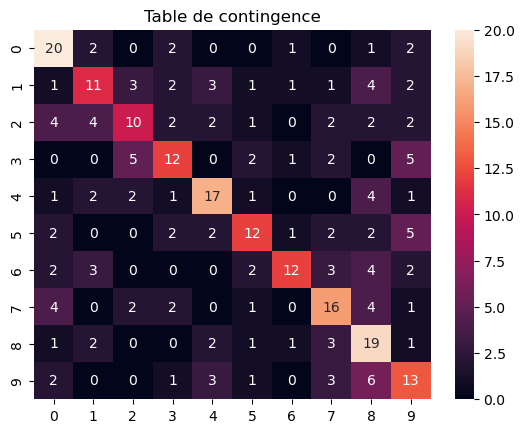

In [ ]:
print("accuracy ... ",accuracy_score(label_y_test,label_y_pred))
print(classification_report(label_y_test,label_y_pred))
sns.heatmap(confusion_matrix(label_y_test,label_y_pred), fmt=".2g", annot=True)
plt.title("Table de contingence")

#### methodes tutoriel

In [ ]:
Y_pred[0]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 7, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.63988e-23): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


accuracy ...  0.4965277777777778
              precision    recall  f1-score   support

           0       0.75      0.56      0.64      3543
           1       0.52      0.62      0.56      1972
           2       0.48      0.37      0.42      2959
           3       0.63      0.40      0.49      2565
           4       0.49      0.57      0.53      2130
           5       0.46      0.66      0.54      1732
           6       0.52      0.36      0.43      2350
           7       0.49      0.67      0.56      2320
           8       0.53      0.64      0.58      2775
           9       0.46      0.50      0.48      2894

    accuracy                           0.53     25240
   macro avg       0.53      0.54      0.52     25240
weighted avg       0.54      0.53      0.52     25240



<Axes: >

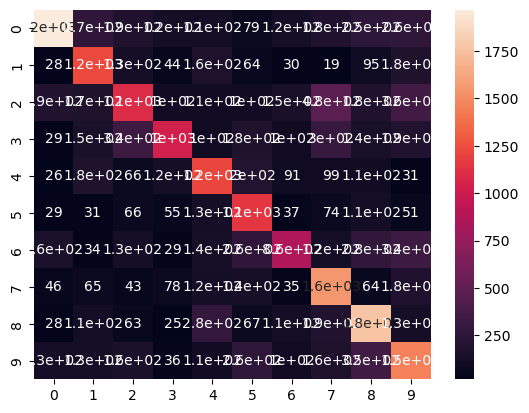

In [ ]:
# Transduction (sequence-to-sequence model)
source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)
model = [source >> reservoir, source] >> readout

# fit & predict
Y_pred = model.fit(X_train, y_train, stateful=False, warmup=2).run(X_test, stateful=False)

# decode output
# There are 9 variables(speakers), hence the output space is 9-dimensional. The variable(speaker) label is the index of the output neuron with maximum activation.
Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
Y_test_class = [np.argmax(y_t, axis=1) for y_t in y_test]

score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))

# print("Accuracy: ", f"{score * 100:.3f} %")

print("accuracy ... ",accuracy_score(label_y_test,label_y_pred))
print(classification_report(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0)))
sns.heatmap(confusion_matrix(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0)), fmt=".2g", annot=True)

accuracy ...  0.4583333333333333
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        35
           1       0.48      0.40      0.43        25
           2       0.46      0.50      0.48        32
           3       0.46      0.21      0.29        29
           4       0.37      0.61      0.46        23
           5       0.39      0.55      0.46        20
           6       0.58      0.24      0.34        29
           7       0.38      0.42      0.40        26
           8       0.40      0.50      0.44        34
           9       0.50      0.60      0.55        35

    accuracy                           0.46       288
   macro avg       0.47      0.46      0.45       288
weighted avg       0.48      0.46      0.45       288



/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_47816/4065693293.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_y_pred = [int(time_serie[-1]) for time_serie in decoded_preds]
/var/folders/dv/gzhyqctn53s9bh23g7tbvl940000gn/T/ipykernel_47816/4065693293.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_y_test = [int(time_serie[0]) for time_serie in decoded_y_test]


<Axes: >

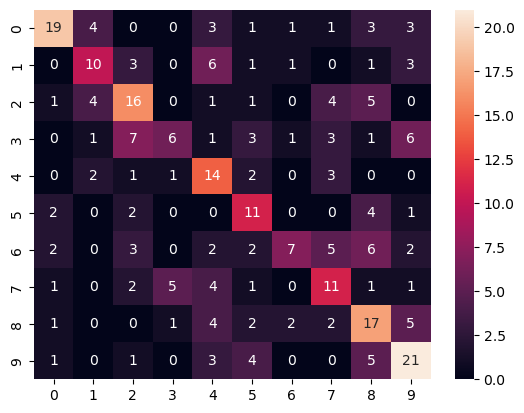

In [ ]:
preds=[]
for i in range(len(Y_pred)):
    res_ = []
    for timestep in range(len(Y_pred[i])):
        u = np.zeros(10)
        u[np.argmax(Y_pred[i][timestep])] = 1
        res_.append(u)
    preds.append(res_)

decoded_preds = [enc.inverse_transform(label) for label in preds]
label_y_pred = [int(time_serie[-1]) for time_serie in decoded_preds]

decoded_y_test = [enc.inverse_transform(label) for label in y_test]   # take n_timestep as prediction
label_y_test = [int(time_serie[0]) for time_serie in decoded_y_test]  

print("accuracy ... ",accuracy_score(label_y_test,label_y_pred))
print(classification_report(label_y_test,label_y_pred))
sns.heatmap(confusion_matrix(label_y_test,label_y_pred), fmt=".2g", annot=True)

source = Input()
reservoir = Reservoir(500, sr=0.9, lr=0.1)
readout = Ridge(ridge=1e-6)

model = source >> reservoir >> readout

In [ ]:
from reservoirpy.nodes import Reservoir, Ridge, Input
import time

results = []
for neurons in 50, 80, 100, 200, 300, 500, 800, 1000, 2000, 3000:
    t0=time.time()
    source = Input()
    reservoir = Reservoir(neurons, sr=0.9, lr=0.1)
    readout = Ridge(ridge=1e-6)
    model = [source >> reservoir, source] >> readout   # modele 2 connecte 
    model = model.fit(X_train, y_train, stateful=False, warmup=2)
    time_fit = time.time() - t0
    Y_pred = model.run(X_test, stateful=False)
    time_pred = time.time()-t0-time_fit
    Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
    Y_test_class = [np.argmax(y_t, axis=1) for y_t in y_test]

    #train score
    Y_pred_train = model.run(X_train, stateful=False)
    Y_pred_train_class = [np.argmax(y_p, axis=1) for y_p in Y_pred_train]
    Y_train_class = [np.argmax(y_t, axis=1) for y_t in y_train]

    score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))
    score_train = accuracy_score(np.concatenate(Y_train_class, axis=0), np.concatenate(Y_pred_train_class, axis=0))
    results.append([neurons,score,time_fit,time_pred])


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.2886e-20): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=4.46094e-21): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=8.6462e-22): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=3.74056e-22): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Applications/anaconda3/lib/python3.9/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.71595e-22): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


KeyboardInterrupt: 

<Axes: xlabel='neurons', ylabel='test_score'>

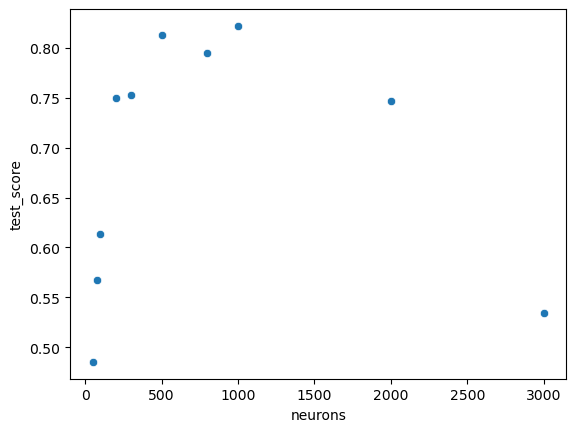

In [ ]:
res_ = pd.DataFrame(results, columns=['neurons','test_score','fit_time','pred_time'])

import seaborn as sns
sns.scatterplot(data=res_,x='neurons',y='test_score')

## deep models

In [ ]:
#Hierarchical ESN 
reservoir1 = Reservoir(100, name="res1-1")
reservoir2 = Reservoir(100, name="res2-1")

readout1 = Ridge(ridge=1e-5, name="readout1-1")
readout2 = Ridge(ridge=1e-5, name="readout2-1")

model = reservoir1 >> readout1 >> reservoir2 >> readout2

model = model.fit(X_train, {"readout1-1": Y_train, "readout2-1": Y_train})

Accuracy:  80.893 %


In [ ]:
#Deep ESN
reservoir1 = Reservoir(100, name="res1-2")
reservoir2 = Reservoir(100, name="res2-2")
reservoir3 = Reservoir(100, name="res3-2")

readout = Ridge(name="readout-2")

model = reservoir1 >> reservoir2 >> reservoir3 & \
        data >> [reservoir1, reservoir2, reservoir3] >> readout

In [ ]:
#Multi input
reservoir1 = Reservoir(100, name="res1-3")
reservoir2 = Reservoir(100, name="res2-3")
reservoir3 = Reservoir(100, name="res3-3")

readout1 = Ridge(name="readout2")
readout2 = Ridge(name="readout1")

model = [reservoir1, reservoir2] >> readout1 & \
        [reservoir2, reservoir3] >> readout2